# Part 2. Practice

#### 1.	Given https://github.com/yutkin/Lenta.Ru-News-Dataset, perform EDA on it focusing on the following:
-	Provide descriptive statistics
-	Anomaly detection   

#### 2.	Given the same dataset,
-		extract the most syntactically weighted N-grams, omitting nonsense (‘казалось бы’, ‘возможно предположить’, etc). The main idea is to extract the most valuable data from the text.
-	Try different models for a topic extraction. Which one performs better? What metrics were used to evaluate the model?

#### Import libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')

import numpy as np
import pandas as pd

import re
import string
from collections import defaultdict

import nltk
from nltk.corpus import stopwords

import stop_words

from pymystem3 import Mystem

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

#### Load and prepare dataset

#### Source of data:
https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta/

In [2]:
%%time
data = pd.read_csv('train_data.csv')

Wall time: 36 s


In [3]:
data.topic.unique()

array(['Библиотека', 'Россия', 'Мир', 'Экономика', 'Интернет и СМИ',
       'Спорт', 'Культура', 'Из жизни', 'Силовые структуры',
       'Наука и техника', 'Бывший СССР', nan, 'Дом', 'Сочи', 'ЧМ-2014',
       'Путешествия', 'Ценности', 'Легпром', 'Бизнес', 'МедНовости',
       'Оружие', '69-я параллель', 'Культпросвет ', 'Крым'], dtype=object)

In order to save time I choose four topics neither too large nor too small. Three of them have approximately the same size and one is 8 time less.

In [4]:
topics = ['Спорт', 'Культура', 'Наука и техника', 'Путешествия']

In [5]:
data = data.loc[data['topic'].isin(topics)]

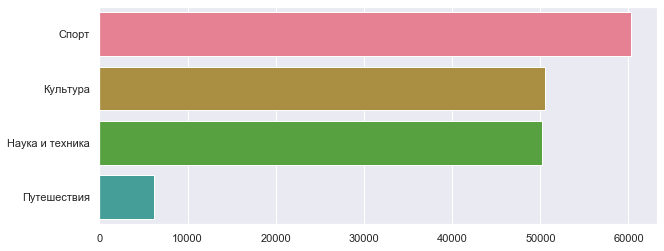

In [6]:
plt.figure(figsize=(10,4))
sns.barplot(x=data.topic.value_counts().values, y=data.topic.value_counts().index);

# The most syntactically weighted N-grams extracting

## Text preprocessing

### Lowercase Text

In [7]:
%%time
def lowercase_text(text):
    text = str(text).lower()
    return text


data['processed_text'] = data['text'].apply(lambda x: lowercase_text(x))

Wall time: 8.31 s


In [8]:
data['processed_text'].head(2)

3753    миланский хоккейный клуб "сайма" получит на по...
3764    в полуфинале кубка италии "венеция" принимала ...
Name: processed_text, dtype: object

### Removing Text Noise

In [9]:
%%time
def remove_noise(text):
    'Removing punctuation, html tags, symbols, numbers, etc.'
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = re.sub('\n', '', text)
    return text


data['processed_text'] = data['processed_text'].apply(lambda x: remove_noise(x))
data['processed_text'].head(2)

Wall time: 6.69 s


3753    миланский хоккейный клуб сайма получит на полм...
3764    в полуфинале кубка италии венеция принимала ри...
Name: processed_text, dtype: object

### Lemmatization

In [10]:
# %%time
# mystem = Mystem()
# data['processed_text'] = data['processed_text'].apply(
#     lambda x:  mystem.lemmatize(x)
# )
# data['processed_text'].head(2)

It is a super slow way to lemmatize more than 100 000 of texts. I tried running %%time but got bored waiting for it to finish.

### Tokenization

In [11]:
%%time
data['processed_text'] = data['processed_text'].apply(
    lambda x:  nltk.word_tokenize(x)
)
data['processed_text'].head(2)

Wall time: 1min 59s


3753    [миланский, хоккейный, клуб, сайма, получит, н...
3764    [в, полуфинале, кубка, италии, венеция, приним...
Name: processed_text, dtype: object

### Removing Stopwords

In [12]:
%%time
STOPWORDS = set(stop_words.get_stop_words('ru'))
def remove_stopwords(text, stopwords):
    token = [token for token in text if token not in stopwords]
    return token
    
    
data['processed_text'] = data['processed_text'].apply(
    lambda x:  (remove_stopwords(x, STOPWORDS))
)
data['processed_text'].head(2)

Wall time: 5.09 s


3753    [миланский, хоккейный, клуб, сайма, получит, п...
3764    [полуфинале, кубка, италии, венеция, принимала...
Name: processed_text, dtype: object

### Stemming

In [13]:
%%time
stemmer = nltk.stem.snowball.RussianStemmer()


def stemming_seq(text, stemmer):
    result = []
    for token in text:
        result.append(stemmer.stem(token))
    return result
    
    
data['processed_text'] = data['processed_text'].apply(
    lambda x:  stemming_seq(x, stemmer)
)
data['processed_text'].head(2)

Wall time: 13min 58s


3753    [миланск, хоккейн, клуб, сайм, получ, полмесяц...
3764    [полуфинал, кубк, итал, венец, принима, римск,...
Name: processed_text, dtype: object

### N-grams

In [14]:
N=20

In [15]:
def generate_ngrams(text, n_gram=1):
    ngrams = zip(*[text[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

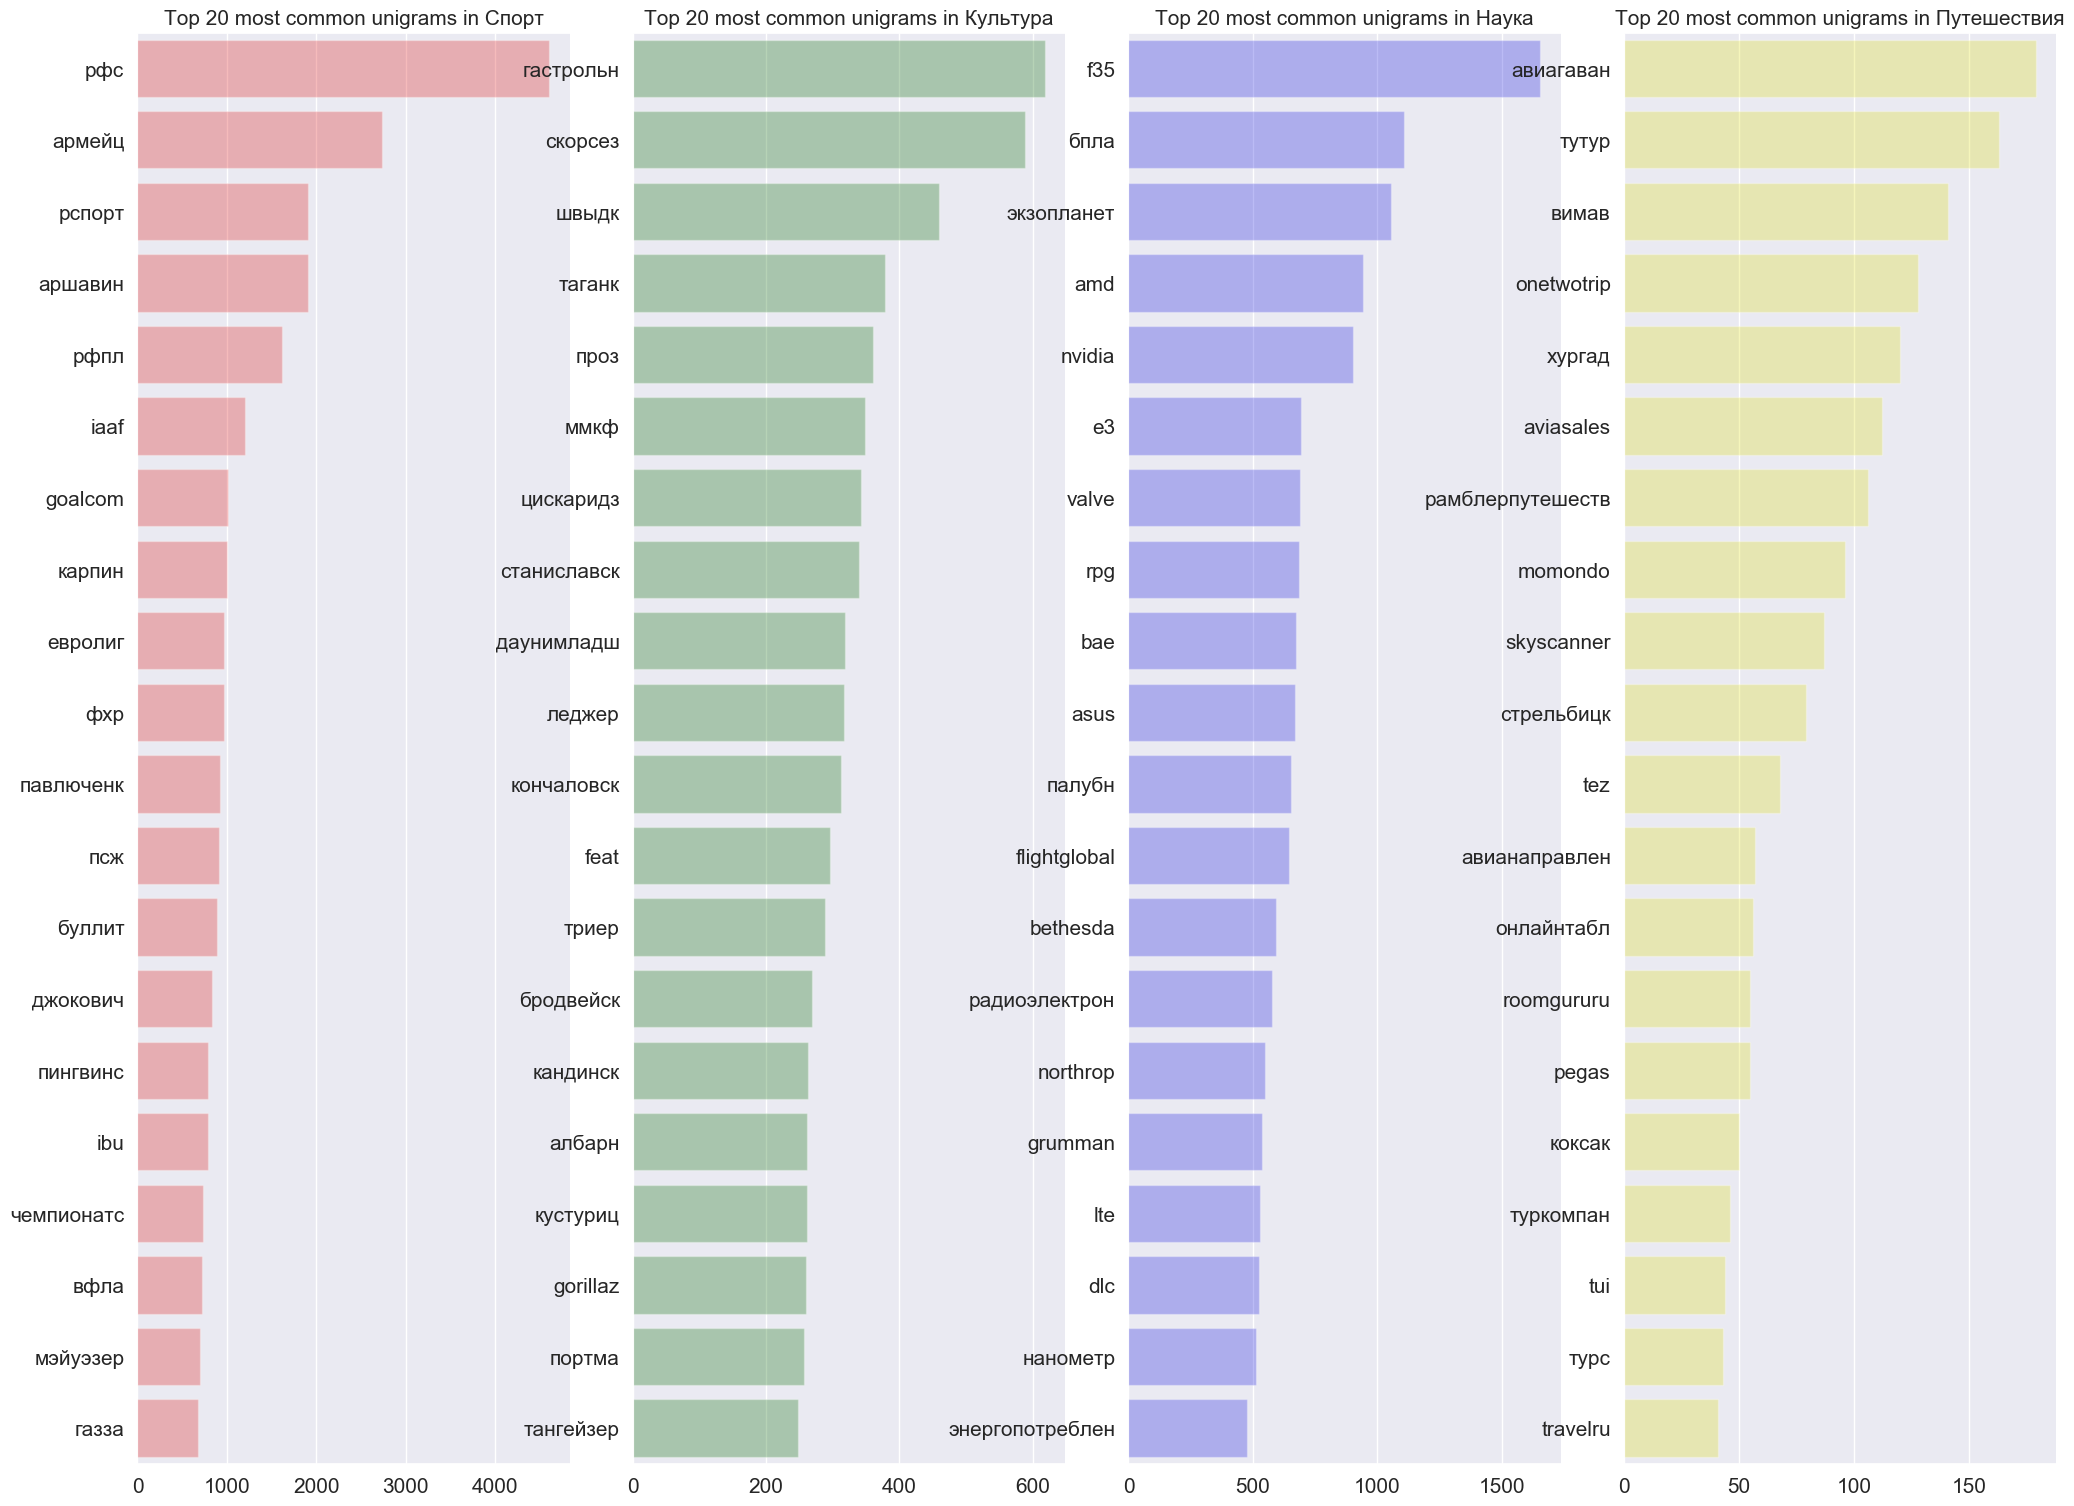

In [16]:
# Unigrams
sport_unigrams = defaultdict(int)
culture_unigrams = defaultdict(int)
sci_unigrams = defaultdict(int)
travel_unigrams = defaultdict(int)

for text in data.loc[data['topic'] == 'Спорт', 'processed_text']:
    for word in generate_ngrams(text):
        sport_unigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Культура', 'processed_text']:
    for word in generate_ngrams(text):        
        culture_unigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Наука и техника', 'processed_text']:
    for word in generate_ngrams(text):   
        sci_unigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Путешествия', 'processed_text']:
    for word in generate_ngrams(text):   
        travel_unigrams[word] += 1

sport_unigrams_keys = set(sport_unigrams.keys())
culture_unigrams_keys = set(culture_unigrams.keys())
sci_unigrams_keys = set(sci_unigrams.keys())
travel_unigrams_keys = set(travel_unigrams.keys())

unique_sport_unigrams = sport_unigrams_keys - culture_unigrams_keys - sci_unigrams_keys - travel_unigrams_keys
unique_sport_unigrams = {k : v for k, v in iter(sport_unigrams.items()) if k in unique_sport_unigrams}

unique_culture_unigrams = culture_unigrams_keys - sci_unigrams_keys - travel_unigrams_keys - sport_unigrams_keys
unique_culture_unigrams = {k : v for k, v in iter(culture_unigrams.items()) if k in unique_culture_unigrams}

unique_sci_unigrams = sci_unigrams_keys - travel_unigrams_keys - sport_unigrams_keys - culture_unigrams_keys
unique_sci_unigrams = {k : v for k, v in iter(sci_unigrams.items()) if k in unique_sci_unigrams}

unique_travel_unigrams = travel_unigrams_keys - sport_unigrams_keys - culture_unigrams_keys - sci_unigrams_keys
unique_travel_unigrams = {k : v for k, v in iter(travel_unigrams.items()) if k in unique_travel_unigrams}

df_sport_unigrams = pd.DataFrame(sorted(unique_sport_unigrams.items(), key=lambda x: x[1])[::-1])
df_culture_unigrams = pd.DataFrame(sorted(unique_culture_unigrams.items(), key=lambda x: x[1])[::-1])
df_sci_unigrams = pd.DataFrame(sorted(unique_sci_unigrams.items(), key=lambda x: x[1])[::-1])
df_travel_unigrams = pd.DataFrame(sorted(unique_travel_unigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=4, figsize=(20, 15), dpi=100)
plt.tight_layout()

sns.barplot(
    y=df_sport_unigrams[0].values[:N], 
    x=df_sport_unigrams[1].values[:N], 
    ax=axes[0], 
    color='red', 
    alpha=0.3
)
sns.barplot(
    y=df_culture_unigrams[0].values[:N], 
    x=df_culture_unigrams[1].values[:N], 
    ax=axes[1], 
    color='green', 
    alpha=0.3
)
sns.barplot(
    y=df_sci_unigrams[0].values[:N], 
    x=df_sci_unigrams[1].values[:N], 
    ax=axes[2], 
    color='blue', 
    alpha=0.3
)
sns.barplot(
    y=df_travel_unigrams[0].values[:N], 
    x=df_travel_unigrams[1].values[:N], 
    ax=axes[3], 
    color='yellow', 
    alpha=0.3
)

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common unigrams in Спорт', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Культура', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Наука', fontsize=15)
axes[3].set_title(f'Top {N} most common unigrams in Путешествия', fontsize=15)

plt.show()

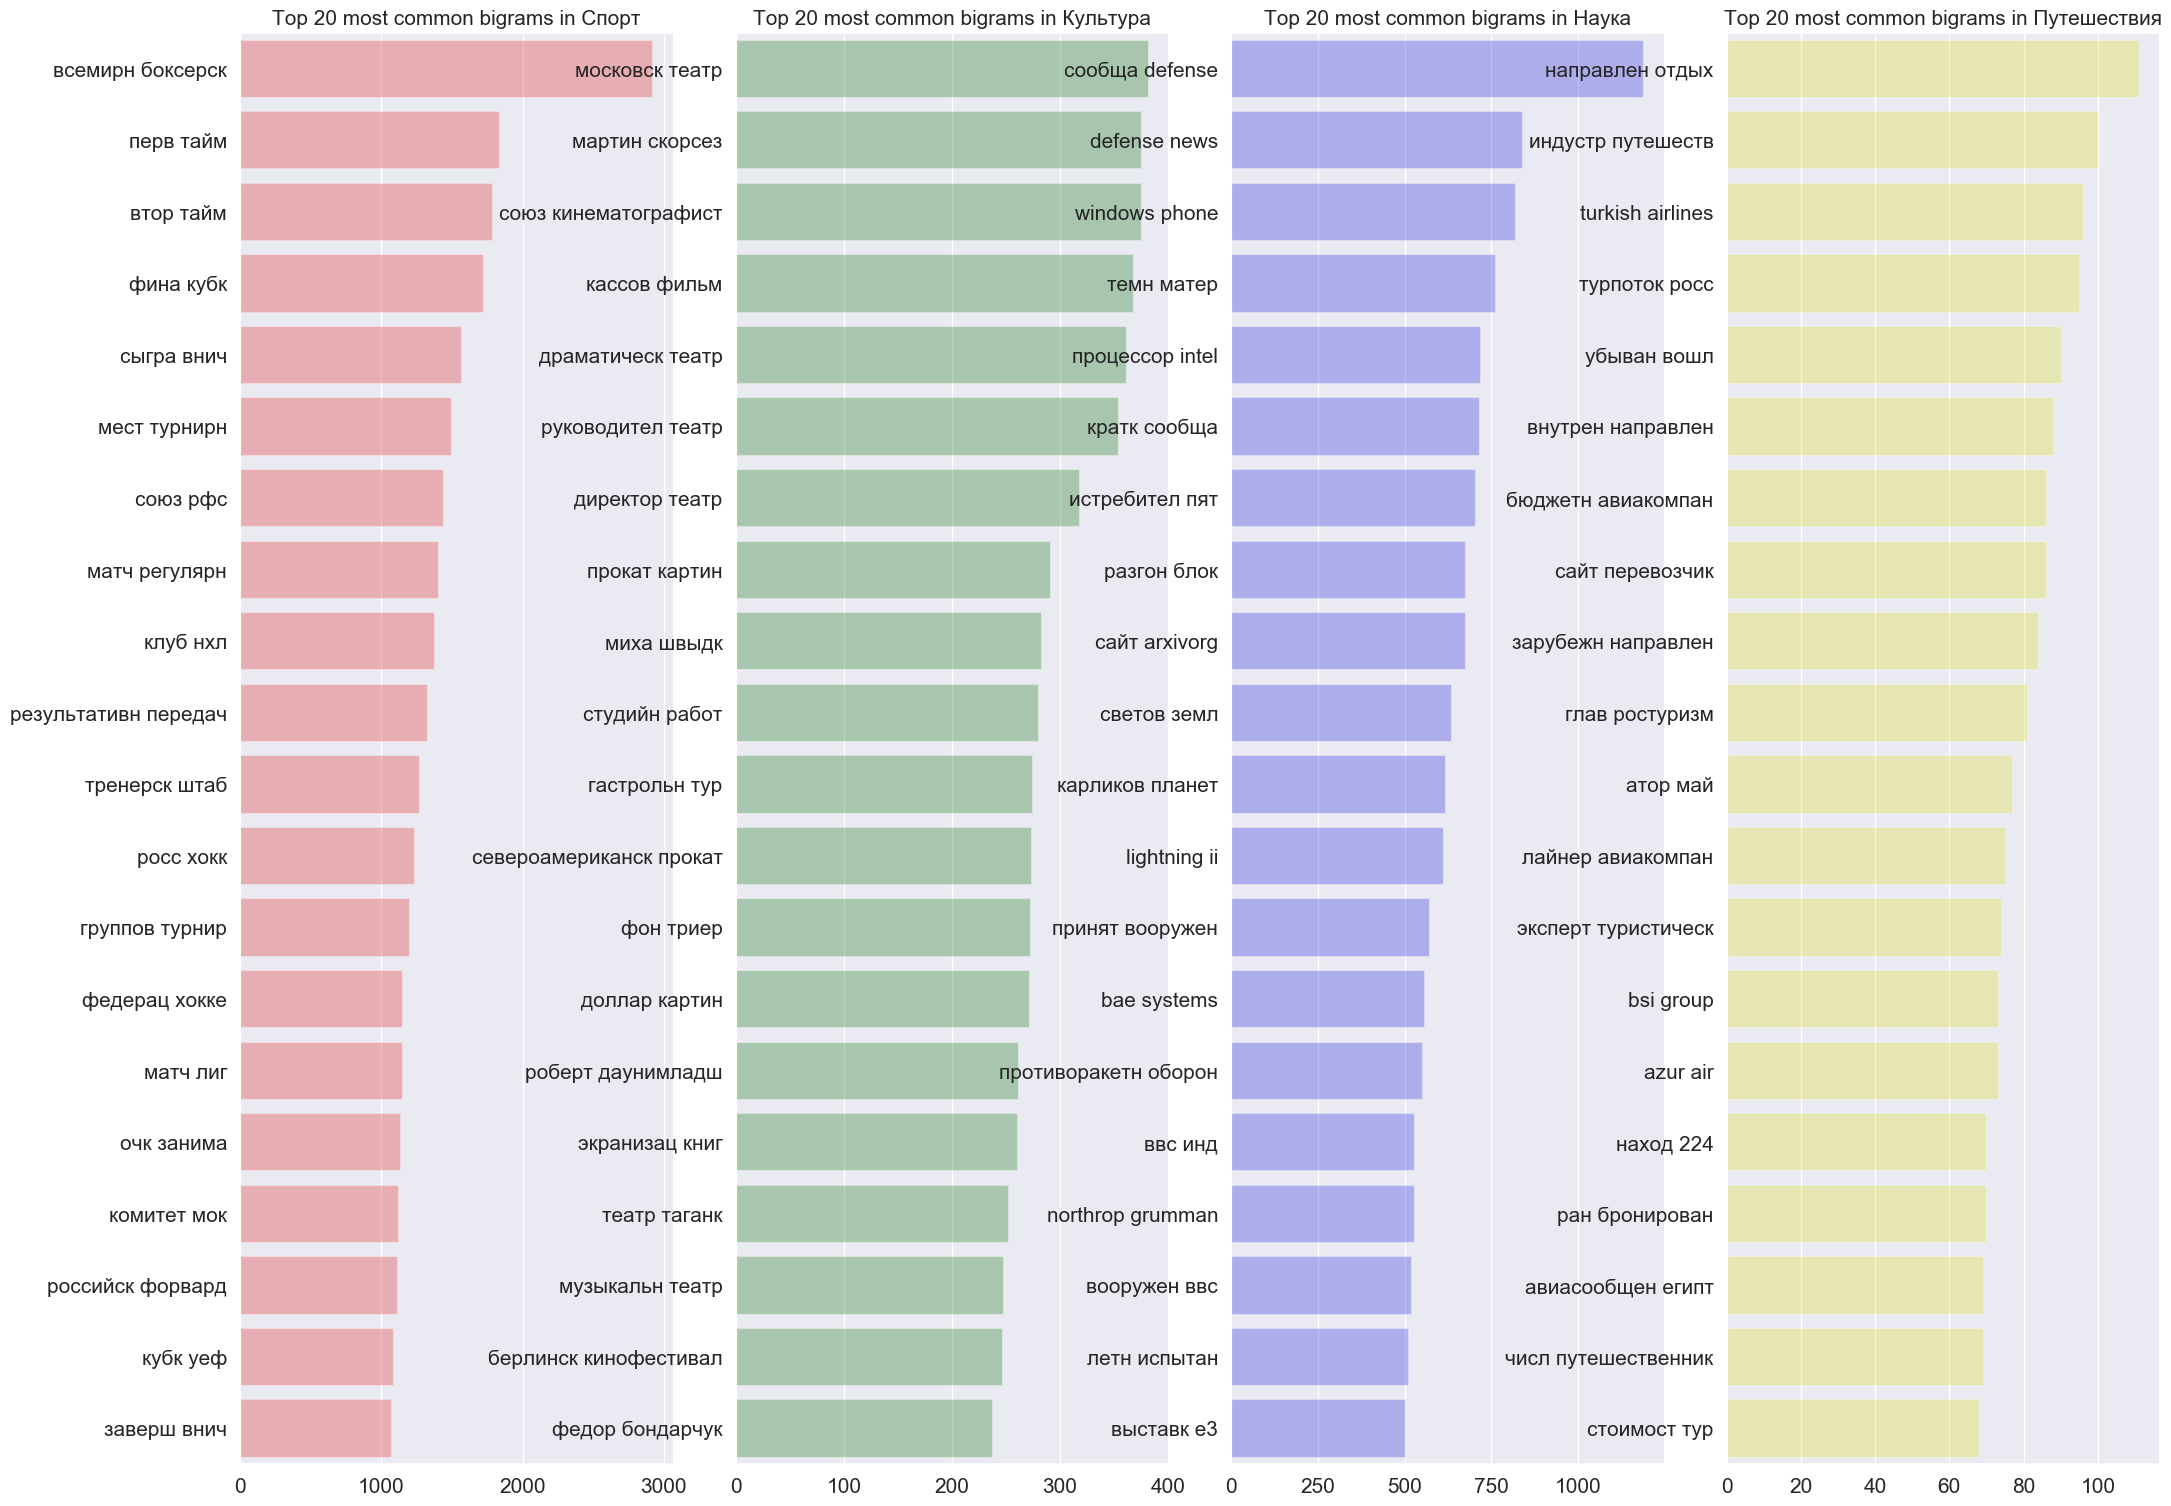

In [17]:
# Bigrams
sport_bigrams = defaultdict(int)
culture_bigrams = defaultdict(int)
sci_bigrams = defaultdict(int)
travel_bigrams = defaultdict(int)

for text in data.loc[data['topic'] == 'Спорт', 'processed_text']:
    for word in generate_ngrams(text, 2):
        sport_bigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Культура', 'processed_text']:
    for word in generate_ngrams(text, 2):        
        culture_bigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Наука и техника', 'processed_text']:
    for word in generate_ngrams(text, 2):   
        sci_bigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Путешествия', 'processed_text']:
    for word in generate_ngrams(text, 2):   
        travel_bigrams[word] += 1

sport_bigrams_keys = set(sport_bigrams.keys())
culture_bigrams_keys = set(culture_bigrams.keys())
sci_bigrams_keys = set(sci_bigrams.keys())
travel_bigrams_keys = set(travel_bigrams.keys())

bique_sport_bigrams = sport_bigrams_keys - culture_bigrams_keys - sci_bigrams_keys - travel_bigrams_keys
bique_sport_bigrams = {k : v for k, v in iter(sport_bigrams.items()) if k in bique_sport_bigrams}

bique_culture_bigrams = culture_bigrams_keys - sci_bigrams_keys - travel_bigrams_keys - sport_bigrams_keys
bique_culture_bigrams = {k : v for k, v in iter(culture_bigrams.items()) if k in bique_culture_bigrams}

bique_sci_bigrams = sci_bigrams_keys - travel_bigrams_keys - sport_bigrams_keys - culture_bigrams_keys
bique_sci_bigrams = {k : v for k, v in iter(sci_bigrams.items()) if k in bique_sci_bigrams}

bique_travel_bigrams = travel_bigrams_keys - sport_bigrams_keys - culture_bigrams_keys - sci_bigrams_keys
bique_travel_bigrams = {k : v for k, v in iter(travel_bigrams.items()) if k in bique_travel_bigrams}

df_sport_bigrams = pd.DataFrame(sorted(bique_sport_bigrams.items(), key=lambda x: x[1])[::-1])
df_culture_bigrams = pd.DataFrame(sorted(bique_culture_bigrams.items(), key=lambda x: x[1])[::-1])
df_sci_bigrams = pd.DataFrame(sorted(bique_sci_bigrams.items(), key=lambda x: x[1])[::-1])
df_travel_bigrams = pd.DataFrame(sorted(bique_travel_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=4, figsize=(20, 15), dpi=100)
plt.tight_layout()

sns.barplot(
    y=df_sport_bigrams[0].values[:N], 
    x=df_sport_bigrams[1].values[:N], 
    ax=axes[0], 
    color='red',
    alpha=0.3
)
sns.barplot(
    y=df_culture_bigrams[0].values[:N], 
    x=df_culture_bigrams[1].values[:N], 
    ax=axes[1], 
    color='green', 
    alpha=0.3
)
sns.barplot(
    y=df_sci_bigrams[0].values[:N], 
    x=df_sci_bigrams[1].values[:N], 
    ax=axes[2], 
    color='blue', 
    alpha=0.3
)
sns.barplot(
    y=df_travel_bigrams[0].values[:N], 
    x=df_travel_bigrams[1].values[:N], 
    ax=axes[3], 
    color='yellow', 
    alpha=0.3
)

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common bigrams in Спорт', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Культура', fontsize=15)
axes[2].set_title(f'Top {N} most common bigrams in Наука', fontsize=15)
axes[3].set_title(f'Top {N} most common bigrams in Путешествия', fontsize=15)

plt.show()

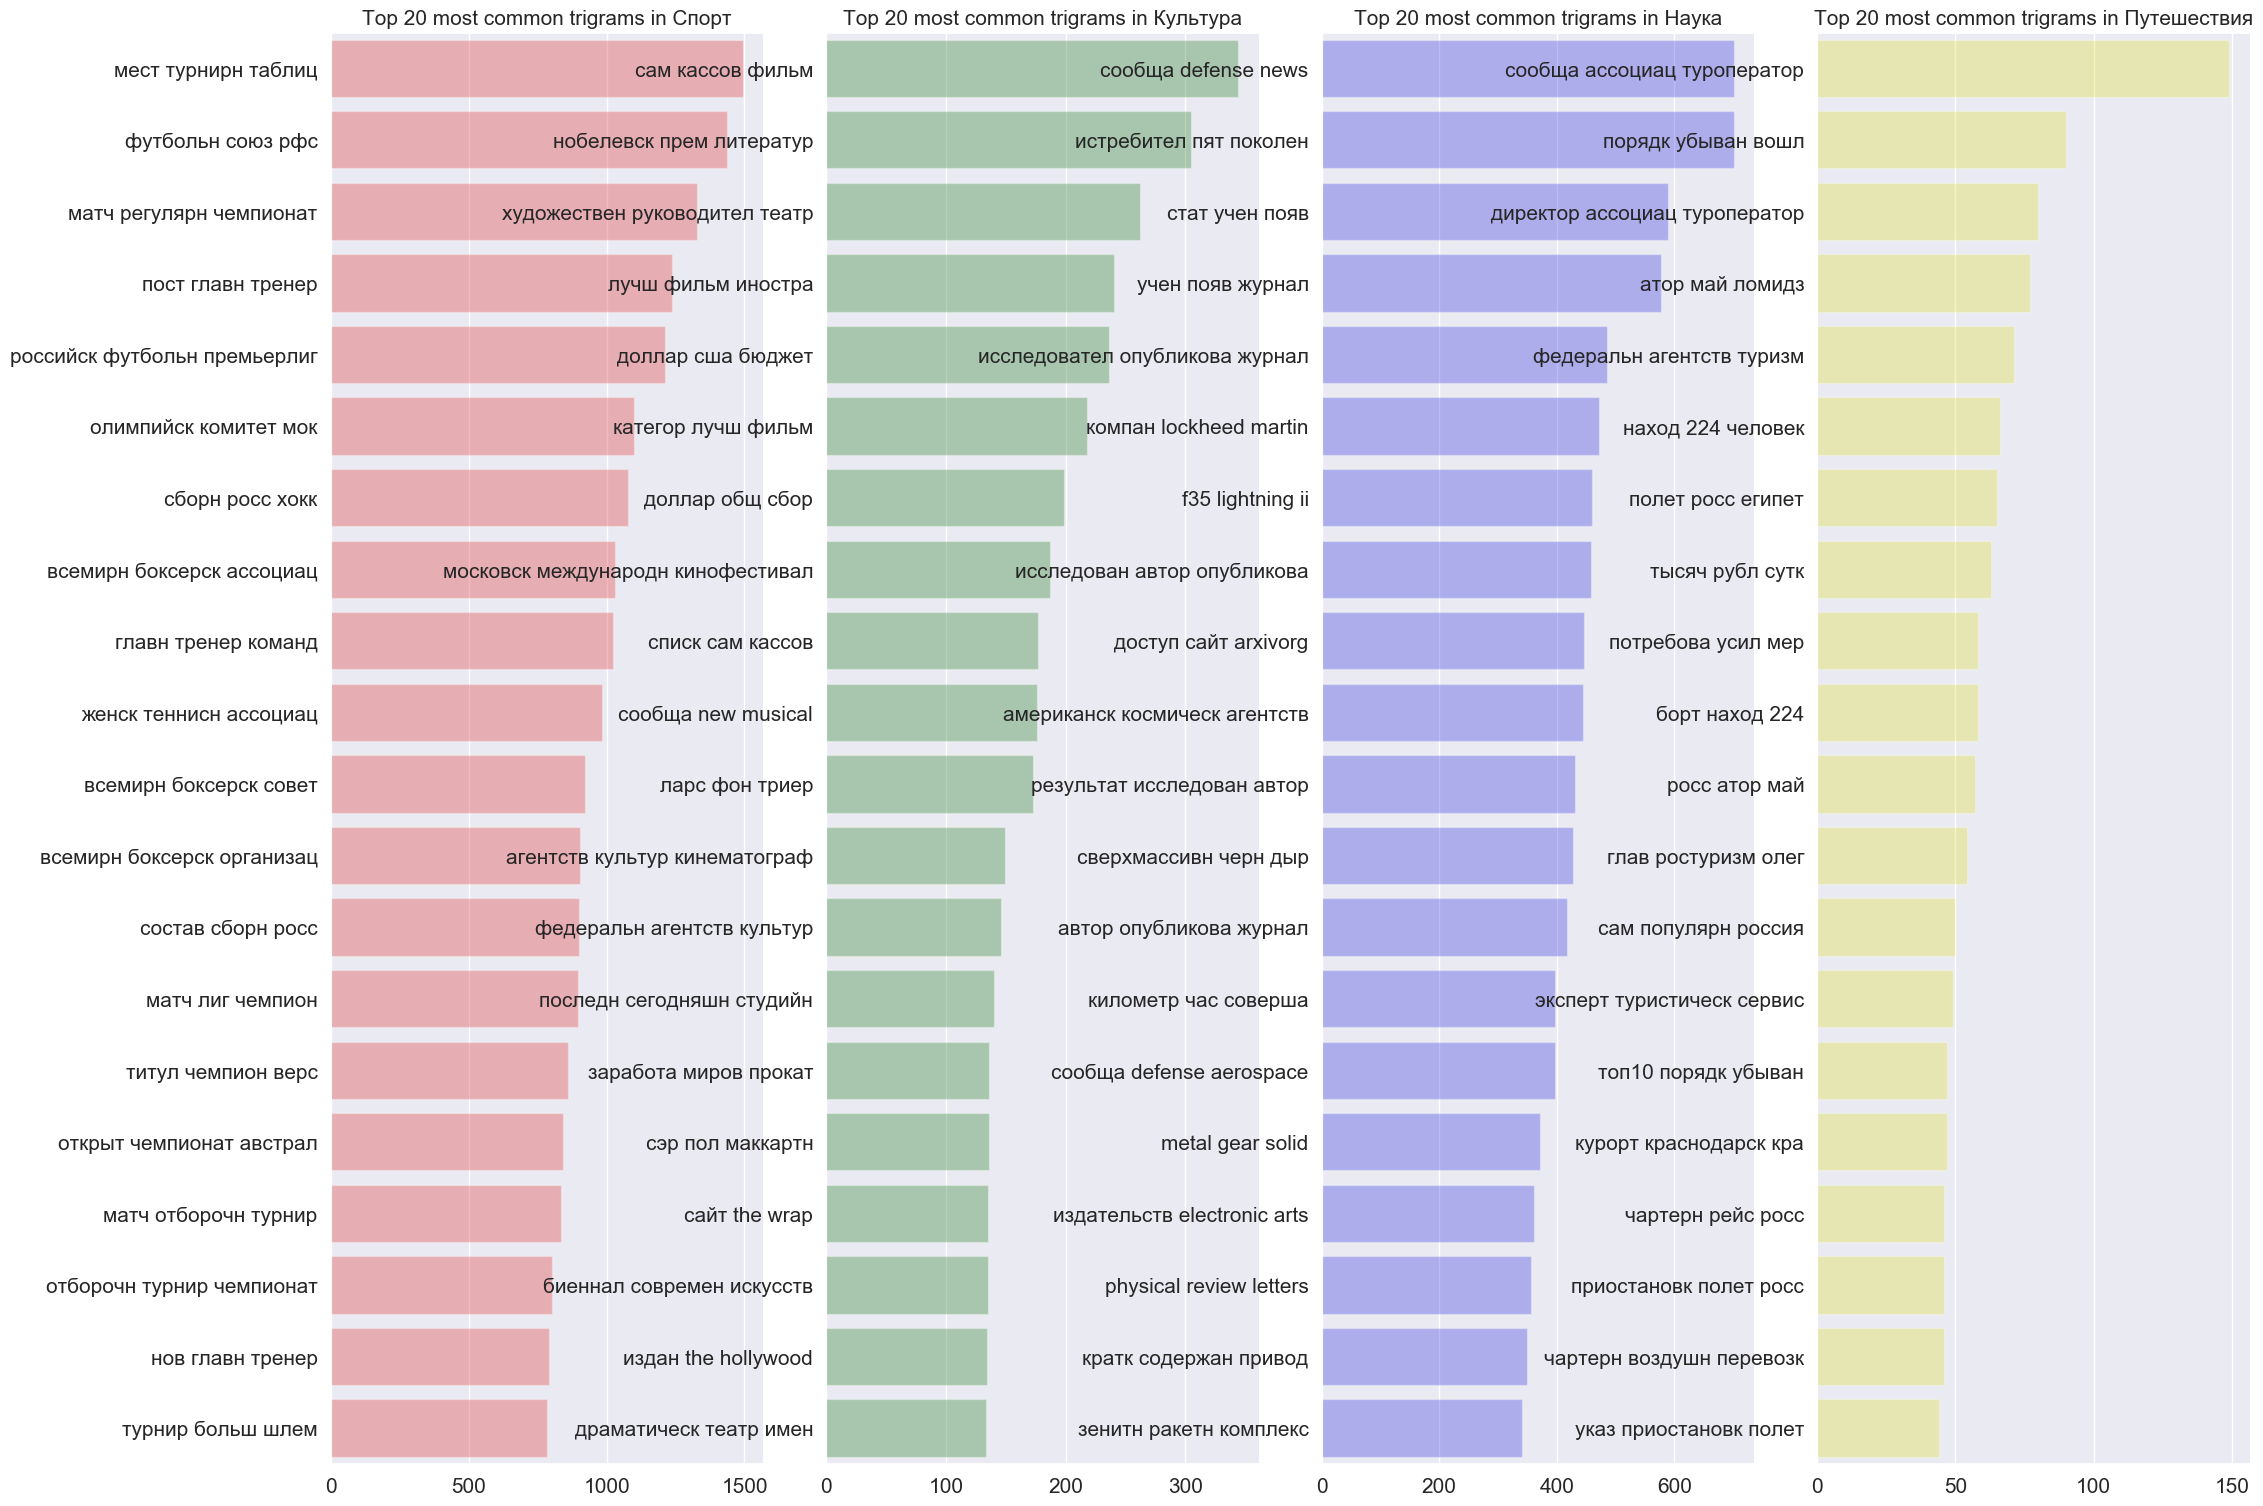

In [18]:
# Trigrams
sport_trigrams = defaultdict(int)
culture_trigrams = defaultdict(int)
sci_trigrams = defaultdict(int)
travel_trigrams = defaultdict(int)

for text in data.loc[data['topic'] == 'Спорт', 'processed_text']:
    for word in generate_ngrams(text, 3):
        sport_trigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Культура', 'processed_text']:
    for word in generate_ngrams(text, 3):        
        culture_trigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Наука и техника', 'processed_text']:
    for word in generate_ngrams(text, 3):   
        sci_trigrams[word] += 1
        
for text in data.loc[data['topic'] == 'Путешествия', 'processed_text']:
    for word in generate_ngrams(text, 3):   
        travel_trigrams[word] += 1

sport_trigrams_keys = set(sport_trigrams.keys())
culture_trigrams_keys = set(culture_trigrams.keys())
sci_trigrams_keys = set(sci_trigrams.keys())
travel_trigrams_keys = set(travel_trigrams.keys())

trique_sport_trigrams = sport_trigrams_keys - culture_trigrams_keys - sci_trigrams_keys - travel_trigrams_keys
trique_sport_trigrams = {k : v for k, v in iter(sport_trigrams.items()) if k in trique_sport_trigrams}

trique_culture_trigrams = culture_trigrams_keys - sci_trigrams_keys - travel_trigrams_keys - sport_trigrams_keys
trique_culture_trigrams = {k : v for k, v in iter(culture_trigrams.items()) if k in trique_culture_trigrams}

trique_sci_trigrams = sci_trigrams_keys - travel_trigrams_keys - sport_trigrams_keys - culture_trigrams_keys
trique_sci_trigrams = {k : v for k, v in iter(sci_trigrams.items()) if k in trique_sci_trigrams}

trique_travel_trigrams = travel_trigrams_keys - sport_trigrams_keys - culture_trigrams_keys - sci_trigrams_keys
trique_travel_trigrams = {k : v for k, v in iter(travel_trigrams.items()) if k in trique_travel_trigrams}

df_sport_trigrams = pd.DataFrame(sorted(trique_sport_trigrams.items(), key=lambda x: x[1])[::-1])
df_culture_trigrams = pd.DataFrame(sorted(trique_culture_trigrams.items(), key=lambda x: x[1])[::-1])
df_sci_trigrams = pd.DataFrame(sorted(trique_sci_trigrams.items(), key=lambda x: x[1])[::-1])
df_travel_trigrams = pd.DataFrame(sorted(trique_travel_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=4, figsize=(20, 15), dpi=100)
plt.tight_layout()

sns.barplot(
    y=df_sport_trigrams[0].values[:N], 
    x=df_sport_trigrams[1].values[:N], 
    ax=axes[0], 
    color='red', 
    alpha=0.3
)
sns.barplot(
    y=df_culture_trigrams[0].values[:N], 
    x=df_culture_trigrams[1].values[:N], 
    ax=axes[1], 
    color='green', 
    alpha=0.3
)
sns.barplot(
    y=df_sci_trigrams[0].values[:N], 
    x=df_sci_trigrams[1].values[:N], 
    ax=axes[2], 
    color='blue', 
    alpha=0.3
)
sns.barplot(
    y=df_travel_trigrams[0].values[:N], 
    x=df_travel_trigrams[1].values[:N], 
    ax=axes[3], 
    color='yellow', 
    alpha=0.3
)

for i in range(4):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'Top {N} most common trigrams in Спорт', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Культура', fontsize=15)
axes[2].set_title(f'Top {N} most common trigrams in Наука', fontsize=15)
axes[3].set_title(f'Top {N} most common trigrams in Путешествия', fontsize=15)

plt.show()

# Topic extraction

In [19]:
topics = data['topic'].unique()
topics

array(['Спорт', 'Культура', 'Наука и техника', 'Путешествия'],
      dtype=object)

In [20]:
replace_dict = {topics[i]: i for i in range(len(topics))}

data['topic'].replace(replace_dict, inplace=True)

In [21]:
X = data['processed_text']
y = data['topic'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

X_train.shape, len(y_train)

((112082,), 112082)

In [22]:
X_train

491122    [мессенджер, viber, запуст, нов, функц, public...
203116    [напада, сборн, франц, футбол, давид, трезег, ...
696359    [российск, фигуристк, елизавет, туктамышев, со...
155284    [хакер, взлома, компьютерн, сет, авторитетн, а...
603480    [российск, актер, алекс, маетн, известн, марку...
                                ...                        
505668    [голливудск, актер, киан, ривз, джим, керр, сн...
439637    [зоолог, обнаруж, соломонск, какад, какад, гоф...
552367    [вашингтон, кэпиталс, истор, клуб, завоева, пр...
614724    [поэт, евген, евтушенк, госпитализирова, сша, ...
513331    [почетн, президент, российск, футбольн, союз, ...
Name: processed_text, Length: 112082, dtype: object

In [23]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [24]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(len(word_index))

247358


In [27]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, padding='post')
print(X_train[0])
print(X_train.shape)

[  7838  22955   1533      5   1300  12857 103105   2421  11466    156
    328    104    841   5754    590     62     38   3215   2645     70
     12   1400      5   1649    307     78    396     73   2421  11466
    807   2009  22955    104    769  10105    258   2957  11466    391
   7002   6378    423    498    651   3208  32432    328   5841   1441
    104   5754    180   3119  11466  12857 103105    185   3236     74
   3215    961    256     44   1895    328  22955     12  10014   2387
    194    992   1649    180   8563   3119    240  11466    104   4110
    171   1974   1462   5739    966   1969  35778   2625    292   5189
   1649   4138   1278   9150   1123   5754  45963  12601    104    966
  11466   2675    362  11466   2983   1627   2964  11466   3499     74
   1598    353   2421   2957    328  22955    148   1533  10056    965
     12  22955    652   5154   1201    423    388   1092     98     12
   1533     88   2180    494   8175    491   7838    873   1575      3
  2295

In [28]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post')

In [29]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

In [30]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [31]:
some_samples = [x[0] for x in iter(train_dataset.take(2))]

some_samples

[<tf.Tensor: shape=(64, 306), dtype=int32, numpy=
 array([[ 3202,   135,    18, ...,     0,     0,     0],
        [  684,    22,   174, ...,     0,     0,     0],
        [ 2448,   158,    96, ...,     0,     0,     0],
        ...,
        [  446, 13685, 11877, ...,     0,     0,     0],
        [ 1617,   120,   635, ...,     0,     0,     0],
        [ 7318,    32,  1336, ...,     0,     0,     0]])>,
 <tf.Tensor: shape=(64, 306), dtype=int32, numpy=
 array([[4830, 1217,  204, ...,    0,    0,    0],
        [  12, 4311,  403, ...,    0,    0,    0],
        [1909, 3210, 1246, ...,    0,    0,    0],
        ...,
        [ 189, 6549, 1281, ...,    0,    0,    0],
        [ 434,   30,   70, ...,    0,    0,    0],
        [  33,  529,    8, ...,    0,    0,    0]])>]

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(247359, 64),
    tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          15830976  
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 15,833,188
Trainable params: 15,833,188
Non-trainable params: 0
_________________________________________________________________


In [33]:
%%time
num_epochs = 2
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset, 
    epochs=num_epochs, 
    validation_data=test_dataset)

Epoch 1/2
1752/1752 [==============================] - 313s 178ms/step - loss: 0.2507 - accuracy: 0.9049 - val_loss: 0.0513 - val_accuracy: 0.98605:26 - loss: - ETA: 5:16 - loss: 1.3122 - ac - ETA: 5:13 - loss: 1.3009 -  - ETA: 5:12 - loss: 1.2904 - accura - ETA: 5:10 - loss: - ETA: 5:05 - loss: - ETA: 5:01 - loss: 1.2569 - accuracy:  - ETA - ETA - ETA: 4:11 - loss: 0.893 - ETA: 4:09 - l - ETA: 4:02 - loss: 0.8103 - ac - ETA: 4:01 - loss: 0.7 - ETA: 3:59 - loss: 0 - ETA:  - ETA: 3:53 - loss: 0.7 - ETA: 3:51 - loss: 0.7280 - accu - ETA: 3:50 - loss: 0.7 - ETA: 3:44 - - ETA: 3:41 - loss: 0.6 - ETA: 3:34 - loss: 0.6319 - ac - ETA: 3:33 - l - ETA: 3:30 - loss: 0 - ETA: 3:28 - l - ETA: 2:57 - ETA - ETA: 2:46 - loss: 0 - - ETA: 2:36 - loss: 0.4 - ETA: 2:34 - loss: 0.4351 - accuracy: 0.82 - ETA: 2:34 - loss: 0.4 - ETA - ETA: 2:28 - - E - ETA: 2:05 - loss: 0.3819 - accu - ETA: 2:04 - loss: 0.3801  - ETA: 2:03 - loss: 0.3777  - ETA: 2:01 - ETA: 1:58 - loss: 0.3711 - accuracy: 0. - ETA: 1:50 - l

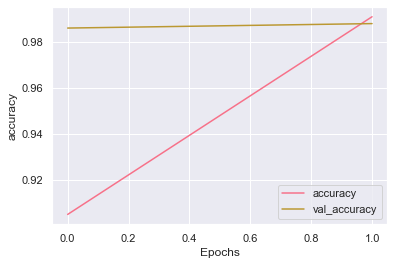

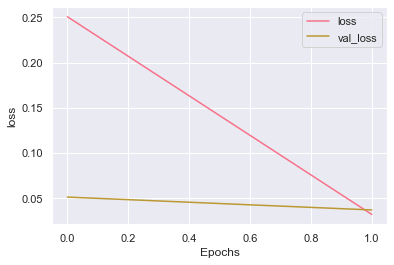

In [34]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")